## TensorFlow Consistency Check

In this example, we demonstrate that our model gives the same output as the original TensorFlow implementation, when using the same image pre-processing. Note that this notebook requires TensorFlow in order to do the pre-processing. 

In [2]:
import json
from PIL import Image

import torch
import tensorflow as tf

from efficientnet_pytorch import EfficientNet

In [9]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

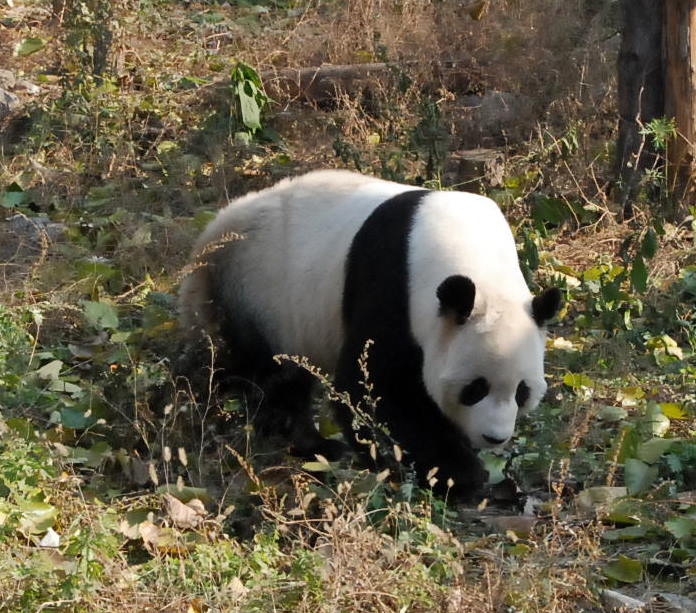

In [4]:
# Show image
Image.open('img.jpg')

In [6]:
# Preprocess image with TensorFlow
tf.enable_eager_execution()

# Constants
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]
CROP_PADDING = 32
image_size = 224

# Helper function
def _decode_and_center_crop(image_bytes, image_size):
    shape = tf.image.extract_jpeg_shape(image_bytes)
    image_height = shape[0]
    image_width = shape[1]
    padded_center_crop_size = tf.cast(
      ((image_size / (image_size + CROP_PADDING)) *
       tf.cast(tf.minimum(image_height, image_width), tf.float32)),
      tf.int32)
    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = tf.stack([offset_height, offset_width, padded_center_crop_size, padded_center_crop_size])
    image = tf.image.decode_and_crop_jpeg(image_bytes, crop_window, channels=3)
    image = tf.image.resize_bicubic([image], [image_size, image_size])[0]
    return image

# Process
tf_img_bytes = tf.read_file('img.jpg')
tf_img = _decode_and_center_crop(tf_img_bytes, image_size)
tf_img = tf.image.resize_bicubic([tf_img], [image_size, image_size])[0] # ok it matches up to here
use_bfloat16 = 224 # bug in the original repo! 
tf_img = tf.image.convert_image_dtype(tf_img, dtype=tf.bfloat16 if use_bfloat16 else tf.float32)
tf_img = tf.cast(tf_img, tf.float32)
tf_img = (tf_img - MEAN_RGB) / (STDDEV_RGB)  # this is exactly the input to the model
img = torch.from_numpy(tf_img.numpy()).unsqueeze(0).permute((0,3,1,2))

In [7]:
# Load class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

In [10]:
# Classify with EfficientNet
model = EfficientNet.from_pretrained(model_name)
model.eval()
with torch.no_grad():
    logits = model(img)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()

print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

Loaded pretrained weights for efficientnet-b0
-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (82.79%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (1.52%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.37%)
American black bear, black bear, Ursus americanus, Euarctos americanus      (0.23%)
brown bear, bruin, Ursus arctos                                             (0.17%)


This is the result obtained by the TensorFlow implementation. 